In [ ]:
# model 1 - Janela deslizante 3 mensagens - V2
# input layer - diferença de posição e rssi
# 2 hidden layers of 7 neurons each
# 1 output neuron
# activator function- ADAM
# loss function - binary cross-entropy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
import time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Mounted at /content/drive


In [ ]:
# modelo
m = 1
# tamanho da janela deslizante
n = 3
veremiPath = "/content/drive/MyDrive/dataset/veremi"
t2Path = "/veremiWithT2"
simcsvPath = '/simulationscsv'
window = "/window"+str(n)+"v2"
model = "/model"+str(m)
preprocessing = "/preprocessing"

# os.chdir(veremiPath+t2Path+window+model+preprocessing)
# os.listdir()

In [ ]:
# preprocessing
start_time = time.time()
os.chdir(veremiPath+t2Path+simcsvPath)
simulations = pd.Series(os.listdir()).sort_values().reset_index(drop=True)
totalsim = len(simulations)
os.chdir(veremiPath+t2Path+window+model+preprocessing)
if os.listdir():
  clist = []
  concluded = pd.Series(os.listdir()).sort_values().reset_index(drop=True)
  for concl in concluded.values:
    c = concl.split('.')
    clist.append(int(c[0][-3:]))
else:
  clist = []
tlist = list(set(range(totalsim)))
remainlist = list(set(tlist) - set(clist))
while remainlist:
  os.chdir(veremiPath+t2Path+window+model+preprocessing)
  concluded = pd.Series(os.listdir()).sort_values().reset_index(drop=True)
  clist = []
  for concl in concluded.values:
    c = concl.split('.')
    clist.append(int(c[0][-3:]))
  remainlist = list(set(tlist) - set(clist))
  if remainlist:
    item = 0
    sim = remainlist[item]
    szremainlist = len(remainlist)
    # start preprocess
    os.chdir(veremiPath+t2Path+simcsvPath)
    data = pd.read_csv(simulations[sim], index_col=0)
    data = data[['receiver', 'sender', 'pos', 'pxRcv', 'pyRcv', 'pzRcv', 'RSSI', 'attackerType']]
    a = pd.Series(data['receiver'].unique().astype(int)).sort_values().reset_index(drop=True)
    b = pd.Series(data['sender'].unique().astype(int)).sort_values().reset_index(drop=True)
    vehicles = pd.concat([a, b], ignore_index=True).unique()
    size = len(vehicles)
    newdata = []
    dataset = []

    for i, r in enumerate(vehicles):
      # if i <= 0:
        for s in data['sender'].loc[data['receiver'] == r].astype(int).unique():
          # print(r, s)
          print('\r',
                'Processing simulation '+str(remainlist[item]),
                ', vehicle '+str(i+1)+' of '+str(size),
                " in {:.2f}".format(time.time() - start_time)+' sec',
                sep='', end='', flush=True)
          l = len(data.loc[(data['receiver'] == r) & (data['sender'] == s)])
          if l >= n:
            atktype = data['attackerType'].loc[(data['receiver'] == r) & (data['sender'] == s)].unique()[0]
            # dividir as mensagens em janelas
            wstart, wend = 0,0
            wshift = 2
            for widx in range(l):
              if widx < wstart or wend >= l:
                continue
              wend = wstart+n
              # get the values of distance and rssi
              for rowidx, row in enumerate(data[['pos', 'pxRcv', 'pyRcv', 'pzRcv', 'RSSI']].loc[(data['sender'] == s) & (data['receiver'] == r)][wstart:wend].values):
                # separação do vetor de posição do remetente
                p = row[0].split(',')
                px = float(p[0][1:])
                py = float(p[1])
                pz = float(p[2][:-1])
                pa = np.array((px, py, pz))
                # vetor de posição do destinatário
                pb = np.array((row[1], row[2], row[3]))
                # cálculo da distância euclideana
                dist = np.linalg.norm(pa-pb)
                rssi = row[4]
                newdata = np.append(newdata, [dist, rssi])
              # zero padding
              for dataidx in range(rowidx*3, 5):
                newdata = np.append(newdata, 0)
              newdata = np.append(newdata, atktype)
              dataset.append(newdata)
              newdata = []
              wstart += wshift


    df = pd.DataFrame(dataset)
    # display(df)
    os.chdir(veremiPath+t2Path+window+model+preprocessing)
    print('\rSaving md1win3'+f"{remainlist[item]:03}"+'.csv', sep='', end='', flush=True)
    df.to_csv('md'+str(m)+'win'+str(n)+f"{remainlist[item]:03}"+'.csv')
    remainlist.pop(item)
print('\rDone in ', "{:.2f}".format(time.time() - start_time)+' sec', sep='', end='', flush=True)

Done in 0.07 sec

In [ ]:
# # preprocessing
# start_time = time.time()
# os.chdir(veremiPath+t2Path+simcsvPath)
# simulations = pd.Series(os.listdir()).sort_values().reset_index(drop=True)
# totalsim = len(simulations)
# os.chdir(veremiPath+t2Path+window+model+preprocessing)
# if os.listdir():
#   concluded = pd.Series(os.listdir()).sort_values().reset_index(drop=True)
#   startsim = concluded.last_valid_index() + 1
# else:
#   startsim = 0
# if totalsim > startsim:
#   dataset = []
#   for idx, item in enumerate(simulations[startsim:totalsim]):
#     # if idx <= 1:
#       os.chdir(veremiPath+t2Path+simcsvPath)
#       data = pd.read_csv(item, index_col=0)
#       data = data[['receiver', 'sender', 'pos', 'pxRcv', 'pyRcv', 'pzRcv', 'RSSI', 'attackerType']]
#       a = pd.Series(data['receiver'].unique().astype(int)).sort_values().reset_index(drop=True)
#       b = pd.Series(data['sender'].unique().astype(int)).sort_values().reset_index(drop=True)
#       vehicles = pd.concat([a, b], ignore_index=True).unique()
#       size = len(vehicles)
#       newdata = []
#       dataset = []

#       for i, r in enumerate(vehicles):
#         # if i <= 0:
#           for s in data['sender'].loc[data['receiver'] == r].astype(int).unique():
#             # print(r, s)
#             print('\r',
#                   'simulation '+str(startsim+idx+1)+' of '+str(totalsim),
#                   ', vehicle '+str(i+1)+' of '+str(size),
#                   " in {:.2f}".format(time.time() - start_time)+' sec',
#                   sep='', end='', flush=True)
#             l = len(data.loc[(data['receiver'] == r) & (data['sender'] == s)])
#             if l >= n:
#               atktype = data['attackerType'].loc[(data['receiver'] == r) & (data['sender'] == s)].unique()[0]
#               # dividir as mensagens em janelas
#               wstart, wend = 0,0
#               wshift = 2
#               for widx in range(l):
#                 if widx < wstart or wend >= l:
#                   continue
#                 wend = wstart+n
#                 # get the values of distance and rssi
#                 for rowidx, row in enumerate(data[['pos', 'pxRcv', 'pyRcv', 'pzRcv', 'RSSI']].loc[(data['sender'] == s) & (data['receiver'] == r)][wstart:wend].values):
#                   # separação do vetor de posição do remetente
#                   p = row[0].split(',')
#                   px = float(p[0][1:])
#                   py = float(p[1])
#                   pz = float(p[2][:-1])
#                   pa = np.array((px, py, pz))
#                   # vetor de posição do destinatário
#                   pb = np.array((row[1], row[2], row[3]))
#                   # cálculo da distância euclideana
#                   dist = np.linalg.norm(pa-pb)
#                   rssi = row[4]
#                   newdata = np.append(newdata, [dist, rssi])
#                 # zero padding
#                 for dataidx in range(rowidx*3, 5):
#                   newdata = np.append(newdata, 0)
#                 newdata = np.append(newdata, atktype)
#                 dataset.append(newdata)
#                 newdata = []
#                 wstart += wshift


#       df = pd.DataFrame(dataset)
#       # display(df)
#       os.chdir(veremiPath+t2Path+window+model+preprocessing)
#       print('\rSaving md1win3'+f"{idx+startsim:03}"+'.csv', sep='', end='', flush=True)
#       df.to_csv('md'+str(m)+'win'+str(n)+f"{idx+startsim:03}"+'.csv')
#   print('\rDone in ', "{:.2f}".format(time.time() - start_time)+' sec', sep='', end='', flush=True)

In [ ]:
os.chdir(veremiPath+t2Path+window+model+preprocessing)
concluded = pd.Series(os.listdir()).sort_values().reset_index(drop=True)
dflist = []
for idx, item in enumerate(concluded):
  print('\r', idx, sep='', end='', flush=True)
  df = pd.read_csv(item, index_col=0, header=0)
  dflist.append(df)
allmsg = pd.concat(dflist)
allmsg = allmsg.reset_index(drop=True)
print('\rSimulations pre-processed:', len(concluded))
print('All msg shape:', allmsg.shape)
# All scenarios 2 - multiclass
allsc2 = allmsg
os.chdir(veremiPath+t2Path+window+model+'/allscenarios2')
allsc2.to_csv('allsc2.csv')
# balanceamento de classes
qtd0 = len(allsc2.iloc[:, -1].loc[allsc2.iloc[:, -1] == 0])
qtd1 = len(allsc2.iloc[:, -1].loc[allsc2.iloc[:, -1] == 1])
qtd2 = len(allsc2.iloc[:, -1].loc[allsc2.iloc[:, -1] == 2])
qtd4 = len(allsc2.iloc[:, -1].loc[allsc2.iloc[:, -1] == 4])
qtd8 = len(allsc2.iloc[:, -1].loc[allsc2.iloc[:, -1] == 8])
qtd16 = len(allsc2.iloc[:, -1].loc[allsc2.iloc[:, -1] == 16])
print('All scenarios distribution:')
print('qtd 0 = ', qtd0, '|', qtd0*100/(qtd0+qtd1+qtd2+qtd4+qtd8+qtd16), '%')
print('qtd 1 = ', qtd1, '|', qtd1*100/(qtd0+qtd1+qtd2+qtd4+qtd8+qtd16), '%')
print('qtd 2 = ', qtd2, '|', qtd2*100/(qtd0+qtd1+qtd2+qtd4+qtd8+qtd16), '%')
print('qtd 4 = ', qtd4, '|', qtd4*100/(qtd0+qtd1+qtd2+qtd4+qtd8+qtd16), '%')
print('qtd 8 = ', qtd8, '|', qtd8*100/(qtd0+qtd1+qtd2+qtd4+qtd8+qtd16), '%')
print('qtd 16 = ', qtd16, '|', qtd16*100/(qtd0+qtd1+qtd2+qtd4+qtd8+qtd16), '%')
# All scenarios 1 - binary
# normalize attackerType to 1
allsc1 = allmsg
allsc1.iloc[:, -1].loc[allsc1.iloc[:, -1] != 0] = 1
os.chdir(veremiPath+t2Path+window+model+'/allscenarios1')
allsc1.to_csv('allsc1.csv')
qtd0 = len(allsc1.iloc[:, -1].loc[allsc1.iloc[:, -1] == 0])
qtd1 = len(allsc1.iloc[:, -1].loc[allsc1.iloc[:, -1] == 1])
print('All scenarios binary distribution:')
print('qtd 0 = ', qtd0, '|', qtd0*100/(qtd0+qtd1), '%')
print('qtd 1 = ', qtd1, '|', qtd1*100/(qtd0+qtd1), '%')

Simulations pre-processed: 225
All msg shape: (18522167, 7)
All scenarios distribution:
qtd 0 =  14885716 | 80.36703264796176 %
qtd 1 =  722349 | 3.8999162463009864 %
qtd 2 =  719979 | 3.88712076724068 %
qtd 4 =  727936 | 3.930080103478173 %
qtd 8 =  725799 | 3.9185425765786475 %
qtd 16 =  740388 | 3.9973076584397496 %
All scenarios binary distribution:
qtd 0 =  14885716 | 80.36703264796176 %
qtd 1 =  3636451 | 19.632967352038236 %


In [ ]:
# All scenarios 1
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MultiLabelBinarizer
os.chdir(veremiPath+t2Path+window+model+'/allscenarios1')
allsc1 = pd.read_csv('allsc1.csv', index_col=0)
allsc1.iloc[:, -1].unique()
# split data and label
data = allsc1.iloc[:, 0:-1].values
classes = allsc1.iloc[:, -1].values
# multilabel binarize
lb = preprocessing.LabelBinarizer()
lb.fit(classes)
lb.classes_
classes = lb.transform(classes)
classes = MultiLabelBinarizer().fit_transform(classes)
# split test and train
data_train, data_test, classes_train, classes_test = train_test_split(data, classes, test_size=0.2, random_state=1)
print('data_train', data_train.shape)
print('data_test', data_test.shape)
print('classes_train', classes_train.shape)
print('classes_test', classes_test.shape)
clTrain = lb.inverse_transform(classes_train)
clTest = lb.inverse_transform(classes_test)
# classes_train
clTrain = pd.Series(clTrain)
qtd0 = len(clTrain.loc[clTrain == 0])
qtd1 = len(clTrain.loc[clTrain == 1])
print('classes_train binary distribution:')
print('qtd 0 = ', qtd0, '|', qtd0*100/(qtd0+qtd1), '%')
print('qtd 1 = ', qtd1, '|', qtd1*100/(qtd0+qtd1), '%')
# classes_test
clTest = pd.Series(clTest)
qtd0 = len(clTest.loc[clTest == 0])
qtd1 = len(clTest.loc[clTest == 1])
print('classes_test binary distribution:')
print('qtd 0 = ', qtd0, '|', qtd0*100/(qtd0+qtd1), '%')
print('qtd 1 = ', qtd1, '|', qtd1*100/(qtd0+qtd1), '%')

data_train (14817733, 6)
data_test (3704434, 6)
classes_train (14817733, 2)
classes_test (3704434, 2)
classes_train binary distribution:
qtd 0 =  11908209 | 80.36458073579811 %
qtd 1 =  2909524 | 19.635419264201886 %
classes_test binary distribution:
qtd 0 =  2977507 | 80.37684029463071 %
qtd 1 =  726927 | 19.623159705369297 %


In [ ]:
# teste com 7 neurônios na camada escondida
# model relu
# 2 hidden layers - 20 neurons each
# 2 output layer - sigmoid
# activation function - SGD
# loss function - 
layer1 = keras.Input(shape=(data_train.shape[1],))
layer2 = keras.layers.Dense(7, activation="relu")(layer1)
layer3 = keras.layers.Dense(7, activation="relu")(layer2)
output = keras.layers.Dense(classes_train.shape[1], activation="softmax")(layer3)
modelrelu = keras.Model(inputs=layer1, outputs=output, name='model'+str(m)+'relu')
print(modelrelu.summary())
# keras.utils.plot_model(model, "my_model.png", show_shapes=True)
modelrelu.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.BinaryAccuracy(),
             tf.keras.metrics.Recall(class_id=1)],
)
# all scenarios 1 - binary
start_time = time.time()
early_stopping = EarlyStopping(
    monitor="loss",
    patience=3,
    min_delta=1e-4,
    restore_best_weights=True
)
modelrelu.fit(
    data_train,
    classes_train,
    epochs=200,
    batch_size=1000,
    callbacks=[early_stopping]
)
print('Done in ', "{:.2f}".format(time.time() - start_time)+' sec', sep='')
modelrelu.save(veremiPath+t2Path+window+model+'/allscenarios1')

Model: "model1relu"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 6)]               0         
                                                                 
 dense_3 (Dense)             (None, 7)                 49        
                                                                 
 dense_4 (Dense)             (None, 7)                 56        
                                                                 
 dense_5 (Dense)             (None, 2)                 16        
                                                                 
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
14818/14818 [==============================] - 40s 3ms/step - loss: 1.1209 - binary_accuracy: 0.8400 - recall_1: 0.2996
Epoch 2/200
14818/14818 [============================

Best Threshold=0.115278, F-Score=0.587
----------------------------------------------------------------------
Classification Report for md1w3binary
              precision    recall  f1-score   support

     class 0      0.905     0.877     0.891   2977507
     class 1      0.553     0.624     0.587    726927

    accuracy                          0.827   3704434
   macro avg      0.729     0.750     0.739   3704434
weighted avg      0.836     0.827     0.831   3704434

----------------------------------------------------------------------


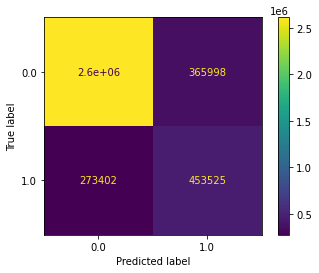

----------------------------------------------------------------------


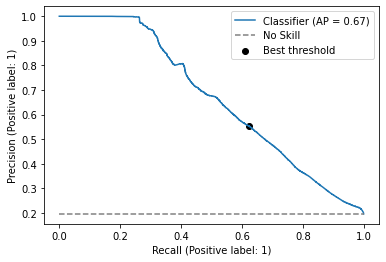

----------------------------------------------------------------------


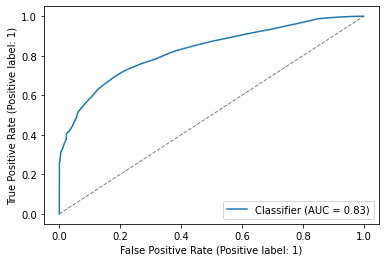

In [ ]:
# All scenarios - model allsc1
# metrics
modelrelu = keras.models.load_model(veremiPath+t2Path+window+model+'/allscenarios1')
predictsrelu = modelrelu.predict(data_test)
clTest = lb.inverse_transform(classes_test)
os.chdir(veremiPath+t2Path+window+model+'/allscenarios1')
# Best threshold
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(clTest, predictsrelu[:, 1], pos_label=1)
# convert to f score
np.seterr(divide='ignore', invalid='ignore')
fscore = (2 * precision * recall) / (precision + recall)
np.nan_to_num(fscore, copy=False)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
print("-"*70)
# Classification Report
from sklearn.metrics import classification_report
# predictsrelu = modelrelu.predict(data_test)
clTest = lb.inverse_transform(classes_test)
predrelu = lb.inverse_transform(predictsrelu, threshold=thresholds[ix])
print('Classification Report for md'+str(m)+'w'+str(n)+'binary')
print(classification_report(clTest, predrelu, target_names=['class 0', 'class 1'], digits=3))
print("-"*70)
# Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# predrelu = lb.inverse_transform(predictsrelu, threshold=thresholds[ix])
cm = confusion_matrix(clTest, predrelu, labels=lb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=lb.classes_)
disp.plot()
# plt.title('md'+str(m)+'w'+str(n)+'binary'+'.pdf')
plt.savefig('md'+str(m)+'w'+str(n)+'binary'+'.pdf')
plt.show()
print("-"*70)
# Precision-Recall curve
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_predictions(clTest, predictsrelu[:, 1], pos_label=1)
# plt.title('PR curve '+'md'+str(m)+'w'+str(n)+'binary'+'.pdf')
no_skill = len(clTest[clTest==1]) / len(clTest)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', color="grey", label='No Skill')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best threshold')
plt.legend()
plt.savefig('PRcurve '+'md'+str(m)+'w'+str(n)+'binary'+'.pdf')
plt.show()
print("-"*70)
# ROC curve
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(clTest, predictsrelu[:, 1], pos_label=1)
# plt.title('ROC curve '+'md'+str(m)+'w'+str(n)+'binary'+'.pdf')
plt.plot([0, 1], [0, 1], color="grey", lw=1, linestyle="--")
plt.savefig('ROCcurve '+'md'+str(m)+'w'+str(n)+'binary'+'.pdf')
plt.show()

In [ ]:
# All scenarios 2
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MultiLabelBinarizer
os.chdir(veremiPath+t2Path+window+model+'/allscenarios2')
allsc2 = pd.read_csv('allsc2.csv', index_col=0)
# allsc2.iloc[:, -1].unique()
# split data and label
data = allsc2.iloc[:, 0:-1].values
classes = allsc2.iloc[:, -1].values
# multilabel binarize
lb = preprocessing.LabelBinarizer()
lb.fit(classes)
lb.classes_
classes = lb.transform(classes)

# split test and train
data_train, data_test, classes_train, classes_test = train_test_split(data, classes, test_size=0.2, random_state=1)
print('data_train', data_train.shape)
print('data_test', data_test.shape)
print('classes_train', classes_train.shape)
print('classes_test', classes_test.shape)
# classes_train
clTrain = lb.inverse_transform(classes_train, threshold=None)
clTrain = pd.Series(clTrain)
qtd0 = len(clTrain.loc[clTrain == 0])
qtd1 = len(clTrain.loc[clTrain == 1])
print('classes_train binary distribution:')
print('qtd 0 = ', qtd0, '|', qtd0*100/(qtd0+qtd1), '%')
print('qtd 1 = ', qtd1, '|', qtd1*100/(qtd0+qtd1), '%')
# classes_test
clTest = lb.inverse_transform(classes_train, threshold=None)
clTest = pd.Series(clTest)
qtd0 = len(clTest.loc[clTest == 0])
qtd1 = len(clTest.loc[clTest == 1])
print('classes_test binary distribution:')
print('qtd 0 = ', qtd0, '|', qtd0*100/(qtd0+qtd1), '%')
print('qtd 1 = ', qtd1, '|', qtd1*100/(qtd0+qtd1), '%')

data_train (14817733, 6)
data_test (3704434, 6)
classes_train (14817733, 6)
classes_test (3704434, 6)
classes_train binary distribution:
qtd 0 =  11908209 | 95.37167952923033 %
qtd 1 =  577897 | 4.62832047076967 %
classes_test binary distribution:
qtd 0 =  11908209 | 95.37167952923033 %
qtd 1 =  577897 | 4.62832047076967 %


In [ ]:
# model multi
# 2 hidden layers - 20 neurons each
# 2 output layer - sigmoid
# activation function - SGD
# loss function - 
layer1 = keras.Input(shape=(data_train.shape[1],))
layer2 = keras.layers.Dense(7, activation="relu")(layer1)
layer3 = keras.layers.Dense(7, activation="relu")(layer2)
output = keras.layers.Dense(classes_train.shape[1], activation="softmax")(layer3)
modelmulti = keras.Model(inputs=layer1, outputs=output, name='model'+str(m)+'multiclass')
print(modelmulti.summary())
# keras.utils.plot_model(model, "my_model.png", show_shapes=True)
modelmulti.compile(
    loss=keras.losses.CategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=[tf.keras.metrics.Accuracy(),
             tf.keras.metrics.Recall(class_id=1)],
)
# all scenarios 2
start_time = time.time()
early_stopping = EarlyStopping(
    monitor="loss",
    patience=3,
    min_delta=1e-4,
    restore_best_weights=True
)
modelmulti.fit(
    data_train,
    classes_train,
    epochs=200,
    batch_size=1000,
    callbacks=[early_stopping]
)
print('Done in ', "{:.2f}".format(time.time() - start_time)+' sec', sep='')
modelmulti.save(veremiPath+t2Path+window+model+'/allscenarios2')

Model: "model1multiclass"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 6)]               0         
                                                                 
 dense_9 (Dense)             (None, 7)                 49        
                                                                 
 dense_10 (Dense)            (None, 7)                 56        
                                                                 
 dense_11 (Dense)            (None, 6)                 48        
                                                                 
Total params: 153
Trainable params: 153
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
14818/14818 [==============================] - 42s 3ms/step - loss: 1.3057 - accuracy: 0.0236 - recall_3: 0.0076
Epoch 2/200
14818/14818 [=============================

Classification Report for md1w3multi
              precision    recall  f1-score   support

     class 0      0.851     0.991     0.916   2977507
     class 1      0.658     0.372     0.475    144452
     class 2      0.000     0.000     0.000    143395
     class 4      0.999     0.989     0.994    145650
     class 8      0.419     0.033     0.060    145158
    class 16      0.000     0.000     0.000    148272

    accuracy                          0.851   3704434
   macro avg      0.488     0.398     0.408   3704434
weighted avg      0.766     0.851     0.796   3704434

----------------------------------------------------------------------


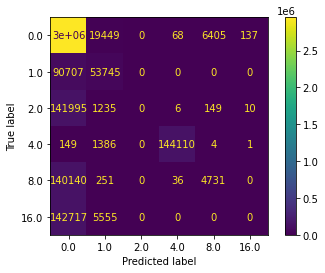

In [ ]:
# All scenarios - model allsc2
# metrics
modelmulti = keras.models.load_model(veremiPath+t2Path+window+model+'/allscenarios2')
# Classification Report
from sklearn.metrics import classification_report
predictsmulti = modelmulti.predict(data_test)
clTest = lb.inverse_transform(classes_test)
predmulti = lb.inverse_transform(predictsmulti, threshold=0.5)
classlist = []
for cl in lb.classes_:
  classlist.append('class '+str(int(cl)))
print('Classification Report for md'+str(m)+'w'+str(n)+'multi')
print(classification_report(clTest,
                            predmulti,
                            target_names=classlist,
                            digits=3,
                            zero_division=0))
print("-"*70)
# Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(clTest, predmulti, labels=lb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=lb.classes_)
disp.plot()
# plt.title('md'+str(m)+'w'+str(n)+'multi'+'.pdf')
plt.savefig('md'+str(m)+'w'+str(n)+'multi'+'.pdf')
plt.show()